In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx

from sklearn import preprocessing
from matplotlib import pyplot as plt
from pyvis.network import Network
from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr

from GGLasso.gglasso.problem import glasso_problem
from utils import transform_features, scale_array_by_diagonal, rename_index_with_sum
from utils import load_data, save_dataframe, process_taxonomy
from utils import filter_zero_features, filter_zero_samples, update_index
from utils import plotly_heatmap, plot_network, _make_heatmap, create_graph, plot_covariates
from utils import plot_ordered_heatmap, hierarchical_clustering, _get_order, create_label_dict
from utils import clean_meta_data, select_covariates, scale_meta_data, merge_data
from utils import calculate_covariance, PCA, create_lambda_mask, create_network_visualization
from utils import project_covariates, process_clust_order, concatenate_PC, scatter_plot

from bokeh.io import output_notebook, show, save
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine, HoverTool, LabelSet, PointDrawTool
from bokeh.plotting import figure
from bokeh.plotting import from_networkx
from bokeh.palettes import RdBu, Blues8
from bokeh.models import HoverTool, Panel, Tabs, ColorBar, LinearColorMapper
from bokeh.layouts import row

# from latentcor import gen_data, get_tps, latentcor
# processed_taxa = (
#     load_data("data/taxonomy.tsv")
#     .pipe(process_taxonomy)
# )
# processed_taxa.head()

### Data preprocessing

In [8]:
filtered_counts=(
    load_data("data/atacama_counts.tsv")
    .pipe(filter_zero_features, threshold=0.8)
    .pipe(filter_zero_samples, threshold=0.95)
    #.pipe(update_index, processed_taxa)
    .pipe(save_dataframe, filename="data/org_named_counts.csv")
    .pipe(rename_index_with_sum)
    .pipe(save_dataframe, filename="data/filtered_counts.csv")
    .pipe(transform_features, transformation="mclr")
    .pipe(save_dataframe, filename="data/mclr_counts.csv")
)
print(filtered_counts.shape)
filtered_counts.head()

(13, 50)


,BAQ2420.1.1,BAQ2420.1.2,BAQ2420.1.3,BAQ2420.2,BAQ2420.3,BAQ2462.1,BAQ2462.2,BAQ2462.3,BAQ2687.1,BAQ2687.2,...,YUN3428.3,YUN3533.1.2,YUN3533.1.3,YUN3533.2,YUN3533.3,YUN3856.1.1,YUN3856.1.2,YUN3856.1.3,YUN3856.2,YUN3856.3
ASV-1,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.934581,0.0,...,0.000000,1.15442,0.0,1.075513,1.109562,0.0,1.250798,0.0,0.520534,1.604619
ASV-2,0.691609,0.000000,0.0,0.976903,0.0,1.259983,0.0,0.858689,0.000000,0.0,...,0.000000,0.00000,0.0,1.517346,1.109562,0.0,1.133015,0.0,1.293724,2.143616
ASV-3,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,1.404585,0.0,...,0.000000,1.15442,0.0,1.586339,0.000000,0.0,0.000000,0.0,1.986871,1.695591
ASV-4,2.007286,1.880850,0.0,0.000000,0.0,1.059312,0.0,0.000000,0.000000,0.0,...,1.663996,0.00000,0.0,0.000000,0.000000,0.0,1.538481,0.0,2.535437,1.994084
ASV-5,0.000000,1.455966,0.0,0.000000,0.0,0.000000,0.0,0.000000,2.806384,0.0,...,0.000000,0.00000,0.0,0.000000,0.000000,0.0,1.304866,0.0,1.501363,2.086457


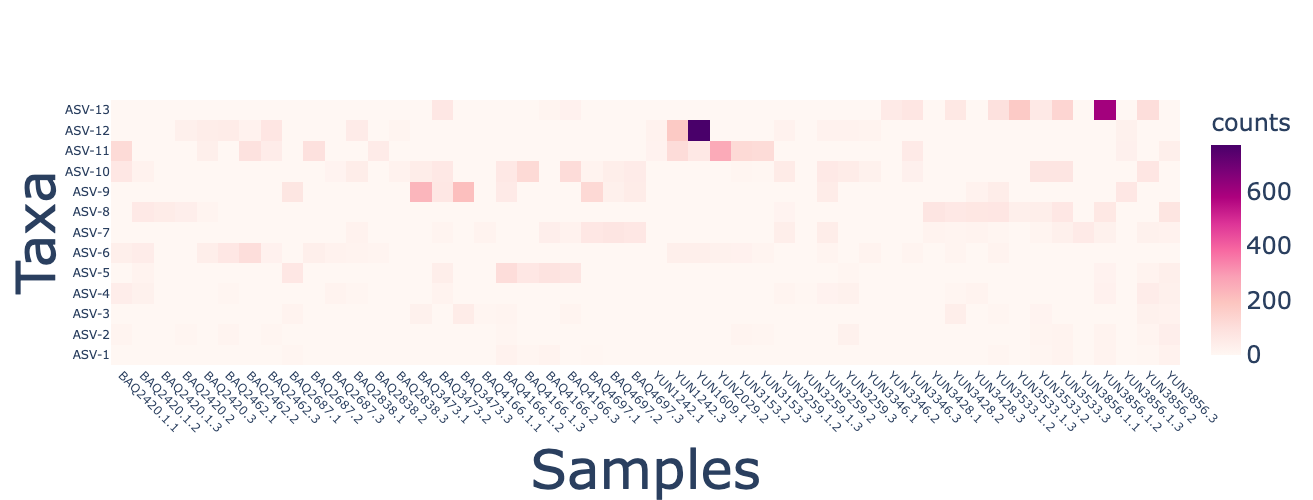

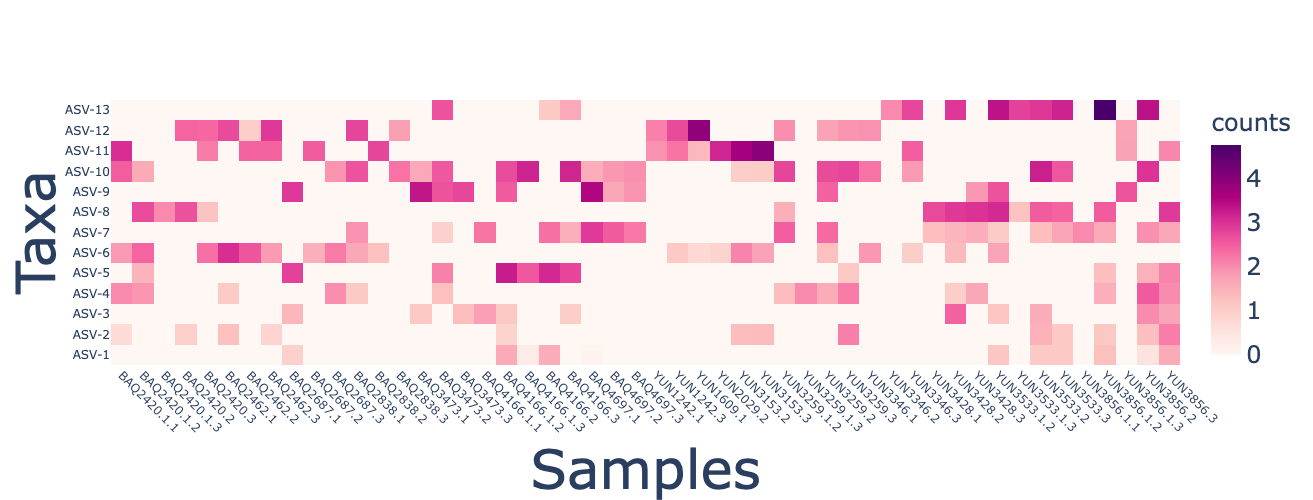

In [4]:
# plot original raw data
filtered_counts = pd.read_csv("data/filtered_counts.csv", index_col=0)
fig_X = plotly_heatmap(z=filtered_counts, x=filtered_counts.columns, y=filtered_counts.index, x_label='Samples', y_label ='Taxa', width=1400, height=500)
fig_X.show()
fig_X.write_image("plots/acm_raw.pdf")
fig_X.write_image("plots/acm_raw.png")
fig_X.write_image("plots/acm_raw.svg")

# plot 'mclr-transformed data
mclr = pd.read_csv("data/mclr_counts.csv", index_col=0)
fig_mclr = plotly_heatmap(z=mclr, x=mclr.columns, y=mclr.index, x_label='Samples', y_label ='Taxa', width=1400, height=500)
fig_mclr.show()
fig_mclr.write_image("plots/acm_mclr.pdf")
fig_mclr.write_image("plots/acm_mclr.png")
fig_mclr.write_image("plots/acm_mclr.svg")

In [5]:
mclr.to_csv('data/mclr_count_table.tsv', sep='\t', index=True)

In [6]:
scaled_covaraites=(
    load_data("data/acm_meta.tsv")
    .pipe(clean_meta_data)
    .pipe(save_dataframe, filename="data/clean_metadata.csv")
    .pipe(select_covariates, ['ph', 'average-soil-relative-humidity', 'elevation', 'average-soil-temperature'])
    .pipe(save_dataframe, filename="data/unscaled_selected_covaraites.csv")
    .pipe(scale_meta_data)
    .pipe(save_dataframe, filename="data/scaled_selected_covaraites.csv")
)
print(scaled_covaraites.shape)
scaled_covaraites.head()

(75, 4)


,ph,average-soil-relative-humidity,elevation,average-soil-temperature
sample-id,,,,
BAQ1370.1.2,0.368754,-1.413475,-1.444382,1.196256
BAQ1370.3,-2.802209,-1.413475,-1.444382,1.196256
BAQ1370.1.3,0.428358,-1.413475,-1.444382,1.196256
BAQ1552.1.1,0.325044,-1.426080,-1.263727,1.199730
BAQ1552.2,-2.802209,-1.426080,-1.263727,1.199730


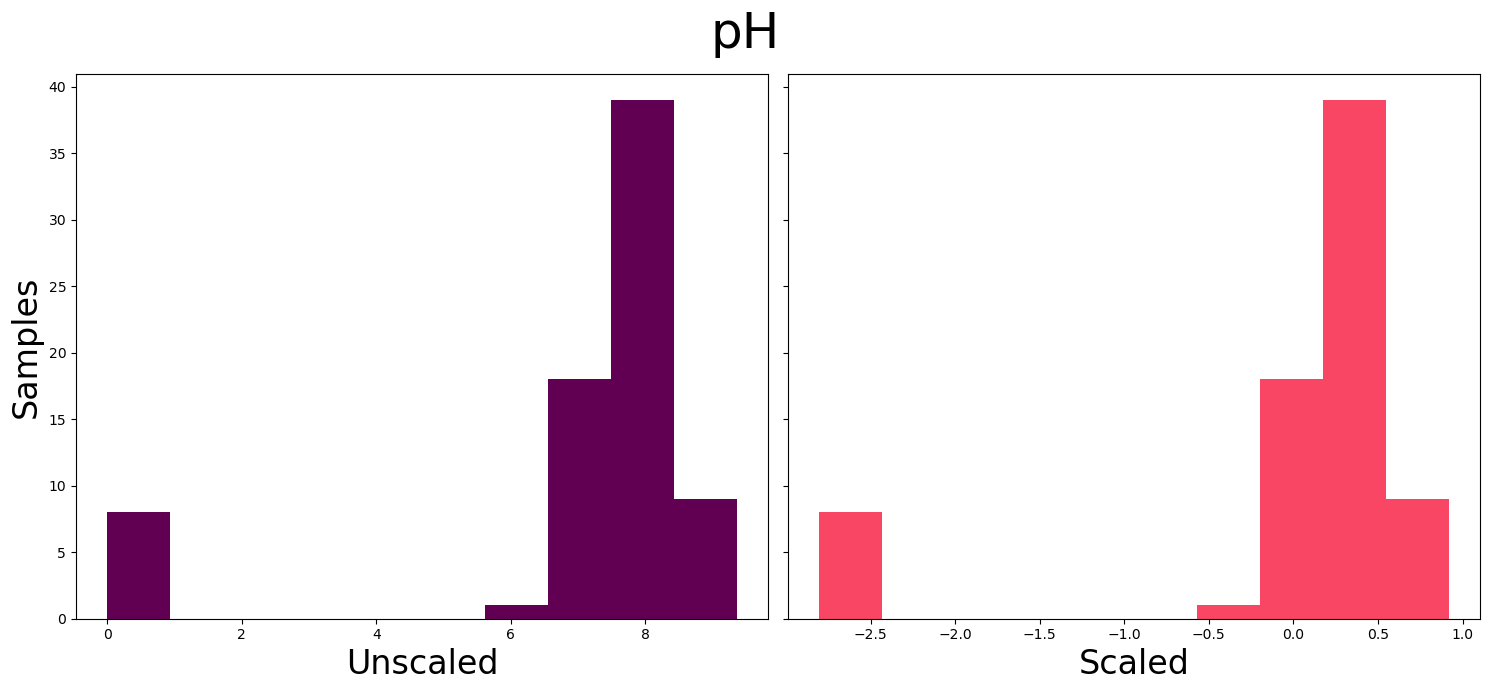

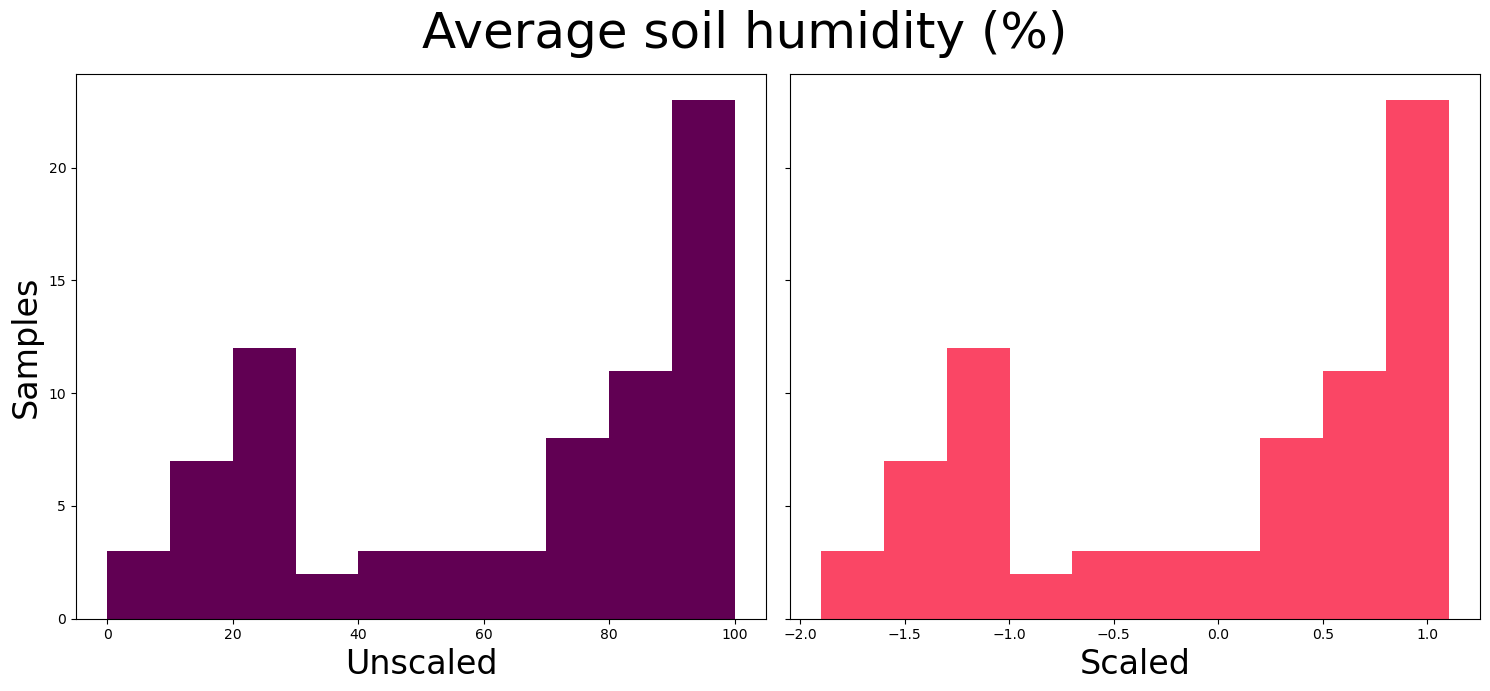

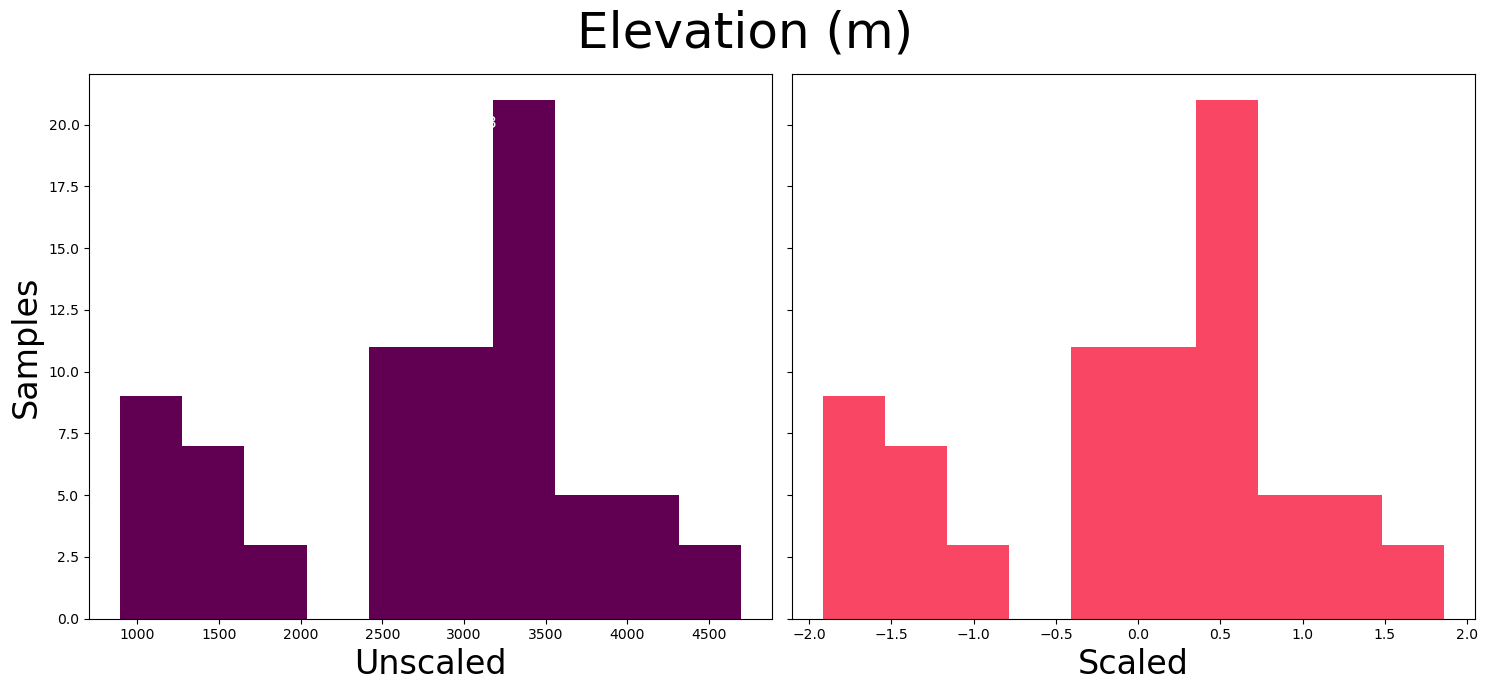

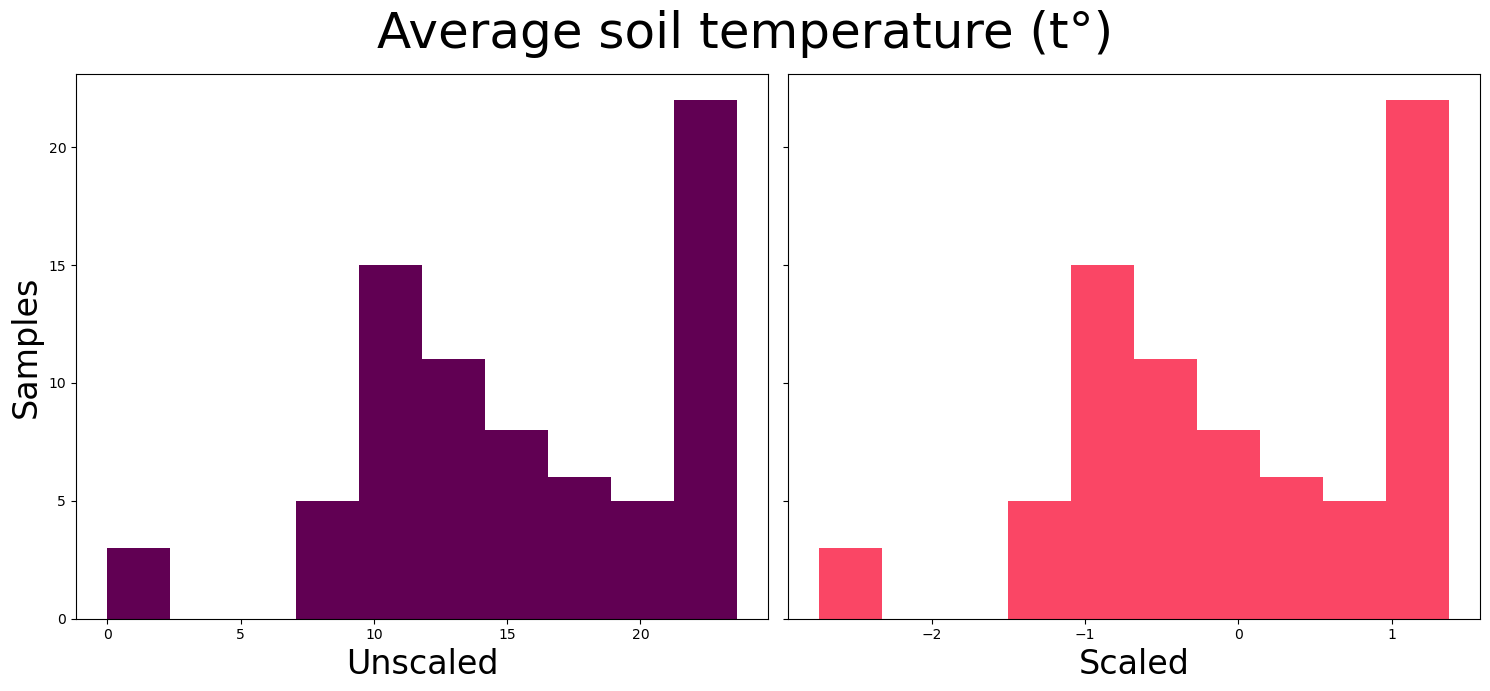

In [2]:
unscaled_covariates = load_data("data/unscaled_selected_covaraites.csv")
scaled_covariates = load_data("data/scaled_selected_covaraites.csv")

plot_covariates(unscaled_covariates, scaled_covariates)

In [8]:
n_cov = scaled_covariates.shape[1]

vis_S = (
    merge_data(mclr, scaled_covariates)
    .pipe(save_dataframe, filename="data/merged_data.csv")
    .pipe(calculate_covariance, n_cov, method="corr")
    .pipe(save_dataframe, filename="data/asv_covariance.csv")
    )

vis_S_meta = (
    load_data("data/merged_data.csv")
    .pipe(calculate_covariance, n_cov=None, method="corr")
    .pipe(save_dataframe, filename="data/asv_meta_covariance.csv")
    )

vis_S.shape, vis_S_meta.shape

((13, 13), (17, 17))

In [9]:
# from scipy.linalg import sqrtm


# diagonal = np.diag(vis_S)
# epsilon = 1e-6  # Small positive constant
# correlation_matrix_modified = vis_S + epsilon * np.eye(vis_S.shape[0])

# sqrt_correlation_matrix = sqrtm(correlation_matrix_modified)

# inverse_sqrt_correlation_matrix = np.linalg.inv(sqrt_correlation_matrix)

# inverse_correlation_matrix = inverse_sqrt_correlation_matrix.dot(inverse_sqrt_correlation_matrix.T)

# test = pd.DataFrame(inverse_correlation_matrix, index=vis_S.index, columns=vis_S.columns)

In [10]:
clust_order = _get_order(vis_S)

p_vis_S_clust = plot_ordered_heatmap(vis_S, order=clust_order)
p_clust_meta = plot_ordered_heatmap(vis_S_meta, order=clust_order, n_covariates=n_cov)

# show(p_vis_S_clust)
show(p_clust_meta)

In [11]:
counts = load_data("data/merged_data.csv")

N = counts.shape[0]
p = counts.shape[1] - n_cov
p_meta = counts.shape[1]
print("Shape of data without covariates: {0}, {1}".format(N, p))
print("Shape of data with covariates: {0}, {1}".format(N, p_meta))

lambda1_range = np.logspace(0, -3, 50)
# mu1_range = np.logspace(-0.2, -0.5, 10)
mu1_range = np.logspace(-0.1, -0.3, 50)
gamma = 0.01

modelselect_params = {'lambda1_range': lambda1_range, 'mu1_range': mu1_range}

P_SGL = glasso_problem(vis_S.values, N, latent=False, do_scaling=False)
P_SGL.model_selection(modelselect_params=modelselect_params, method='eBIC', gamma=gamma)

P_SGL_low = glasso_problem(vis_S.values, N, latent=True, do_scaling=False)
P_SGL_low.model_selection(modelselect_params=modelselect_params, method='eBIC', gamma=gamma)

lambda_mask = create_lambda_mask(counts, p, p_meta)
modelselect_params["lambda1_mask"] = lambda_mask

P_SGL_adapt = glasso_problem(vis_S_meta.values, N, latent=False, do_scaling=False)
P_SGL_adapt.model_selection(modelselect_params=modelselect_params, method='eBIC', gamma=gamma)

Shape of data without covariates: 50, 13
Shape of data with covariates: 50, 17
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 9 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 27 iterations with status: optimal.
ADMM terminated after 27 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 27 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 31 iterations with status: optimal.
ADMM terminated after 34 iterations with status: optimal.
ADMM terminated after 31 iterations with status: optimal.
ADMM terminated after 31 iterations with status: optimal.
ADMM terminated after 41 iterations with status: optimal.
ADMM terminated after 43 iterations with status: opt

In [12]:
print("SGL solution with lambda={lambda1} and mu={mu1}".format(**P_SGL.reg_params))
print("Adaptive SGL+low-rank solution with lambda={lambda1} and mu={mu1}".format(**P_SGL_adapt.reg_params))
print("SGL+low-rank solution with lambda={lambda1} and mu={mu1}".format(**P_SGL_low.reg_params))

SGL solution with lambda=0.42919342601287785 and mu=0
Adaptive SGL+low-rank solution with lambda=0.28117686979742307 and mu=0
SGL+low-rank solution with lambda=0.37275937203149406 and mu=0.5557736586486878


In [13]:
mu1_range = np.logspace(-0.2, -0.3, 50)
mu1_range

array([0.63095734, 0.62799933, 0.62505519, 0.62212485, 0.61920825,
       0.61630532, 0.613416  , 0.61054023, 0.60767794, 0.60482907,
       0.60199355, 0.59917132, 0.59636233, 0.59356651, 0.59078379,
       0.58801412, 0.58525743, 0.58251367, 0.57978277, 0.57706467,
       0.57435932, 0.57166665, 0.5689866 , 0.56631912, 0.56366414,
       0.56102161, 0.55839147, 0.55577366, 0.55316812, 0.5505748 ,
       0.54799363, 0.54542456, 0.54286754, 0.54032251, 0.53778941,
       0.53526818, 0.53275878, 0.53026113, 0.5277752 , 0.52530092,
       0.52283824, 0.52038711, 0.51794747, 0.51551926, 0.51310244,
       0.51069695, 0.50830274, 0.50591975, 0.50354793, 0.50118723])

In [14]:
lambda1_range

array([1.        , 0.86851137, 0.75431201, 0.65512856, 0.5689866 ,
       0.49417134, 0.42919343, 0.37275937, 0.32374575, 0.28117687,
       0.24420531, 0.21209509, 0.184207  , 0.15998587, 0.13894955,
       0.12067926, 0.10481131, 0.09102982, 0.07906043, 0.06866488,
       0.05963623, 0.05179475, 0.04498433, 0.0390694 , 0.03393222,
       0.02947052, 0.02559548, 0.02222996, 0.01930698, 0.01676833,
       0.01456348, 0.01264855, 0.01098541, 0.00954095, 0.00828643,
       0.00719686, 0.00625055, 0.00542868, 0.00471487, 0.00409492,
       0.00355648, 0.00308884, 0.0026827 , 0.00232995, 0.00202359,
       0.00175751, 0.00152642, 0.00132571, 0.0011514 , 0.001     ])

In [15]:
P_SGL_low.modelselect_stats["BEST"]

{'lambda1': 0.37275937203149406, 'mu1': 0.5557736586486878}

In [16]:
tmp = P_SGL_low.solution.lowrank_

np.linalg.matrix_rank(tmp)

2

In [17]:
P_SGL_low.modelselect_stats["BIC"]

{0.1: array([[657.42215312, 656.90565939, 656.40155106, ..., 694.14842717,
         693.323855  , 692.51572481],
        [657.42215888, 656.90565939, 656.40155106, ..., 694.14842717,
         693.323855  , 692.51572481],
        [657.42215888, 656.90565939, 656.40155106, ..., 694.14842717,
         693.323855  , 692.51572481],
        ...,
        [849.66113532, 849.6611242 , 849.66112414, ..., 849.66112414,
         849.66112414, 849.66112414],
        [849.64349996, 849.64351088, 849.64351087, ..., 849.64351087,
         849.64351087, 849.64351087],
        [849.63006611, 849.63009236, 849.63009238, ..., 849.63009238,
         849.63009238, 849.63009238]]),
 0.5: array([[ 657.42215312,  656.90565939,  656.40155106, ...,  694.14842717,
          693.323855  ,  692.51572481],
        [ 657.42215888,  656.90565939,  656.40155106, ...,  694.14842717,
          693.323855  ,  692.51572481],
        [ 657.42215888,  656.90565939,  656.40155106, ...,  694.14842717,
          693.323855  ,  

In [18]:
width = 1500
height = 1500
label_size = "16pt"
asv_names = vis_S.columns
meta_names = vis_S_meta.columns


# for visualization reasons we transform inverse covaraince to negative inverse covaraince, i.e., multiply by -1
sgl = -3.5 * pd.DataFrame(P_SGL.solution.precision_, columns=asv_names, index=asv_names) # we scale the color by 3.5 for the example
adapt = -1 * pd.DataFrame(P_SGL_adapt.solution.precision_, columns=meta_names, index=meta_names)
low = -1 * pd.DataFrame(P_SGL_low.solution.precision_, columns=asv_names, index=asv_names)
lrp = -1 * pd.DataFrame(P_SGL_low.solution.lowrank_, columns=asv_names, index=asv_names)


p_sgl = plot_ordered_heatmap(sgl, order=clust_order, 
                     title="SGL estimated (negative) inverse covariance")
p_adapt = plot_ordered_heatmap(adapt, order=clust_order, n_covariates=n_cov, 
                     title="Adaptive estimated (negative) inverse covariance")
p_low = plot_ordered_heatmap(low, order=clust_order, 
                     title="SGL+low-rank estimated (negative) inverse covariance")

p_lrp = plot_ordered_heatmap(5*lrp, order=clust_order, title="Low-rank")

show(p_sgl)
show(p_adapt)
show(p_low)
show(p_lrp)

# a= lrp.iloc[:, 4].values

# # matrix = np.outer(a, -1*a)
# print(matrix)

In [19]:
# # Define the labels dictionary
# toy_labels = {'ASV2': 'A', 'ASV7': 'B', 'ASV8': 'C', 'ASV11': 'D'}

# # Perform renaming for each DataFrame
# dfs = [sgl, adapt, low, lrp, vis_S]

# for df in dfs:
#     # Rename the index labels
#     df.rename(index=toy_labels, inplace=True)
    
#     # Rename the column labels
#     df.rename(columns=toy_labels, inplace=True)

In [20]:
vis_S_clust = hierarchical_clustering(vis_S, clust_order)

In [21]:
### for 0.9
# test = ['g__Nitriliruptoraceae', "ASV7", 'g__wb1-P19']
#test = ["ASV8", "ASV16", 'g__Nitriliruptoraceae', "ASV20", "ASV7", "ASV12", 'g__wb1-P19', 'g__Nitrosococcus']
# test = ["ASV16", 'g__Nitriliruptoraceae', "ASV8", "ASV23", "ASV12", 'g__wb1-P19']
# test = [ "A", "B", "C", "D"]
test = [ "ASV-6", "ASV-11", "ASV-1", "ASV-5"]
#test = ['g__Nitriliruptoraceae', 'g__Gaiella', 'g__Rokubacteriales', 'g__Candidatus_Nitrososphaera', 'g__wb1-P19', 'g__Nitrosococcus']
# asv_meta = list(meta_names[-n_cov:]) + test
asv_meta = ['average-soil-temperature', 'average-soil-relative-humidity', 'elevation', 'ph'] + test

sgl_edges = sgl[sgl.columns.intersection(asv_meta)].loc[test]
adapt_edges = adapt[adapt.columns.intersection(asv_meta)].loc[asv_meta]
low_edges = low[low.columns.intersection(asv_meta)].loc[test]
org_edges = vis_S_clust[vis_S_clust.columns.intersection(asv_meta)].loc[test]

G_SGL = create_graph(sgl_edges, threshold=0.0)
G_adapt = create_graph(adapt_edges, threshold=0.0)
G_low = create_graph(low_edges, threshold=0.0)
G_org = create_graph(org_edges, threshold=0.0)

In [22]:
test = create_network_visualization(G_org, height=500, width=800, show_labels=False, size_degree=True, scale_edge=20, scale_node=17)
test.show('plots/network.html')

plots/network.html


In [23]:
test = create_network_visualization(G_SGL, height=500, width=800, show_labels=False, size_degree=True, scale_edge=20, scale_node=17)
test.show('plots/network.html')

plots/network.html


In [24]:
# G_low.add_node("A")
# G_low.add_node("B")

test = create_network_visualization(G_low, height=500, width=800, show_labels=False, size_degree=True, scale_edge=50, scale_node=17)
test.show('plots/network.html')

plots/network.html


In [25]:
test = create_network_visualization(G_adapt, height=500, width=800, show_labels=False, size_degree=True, scale_edge=2, scale_node=7)
test.show('plots/network.html')

plots/network.html


In [26]:
def project_covariates(transformed_counts=pd.DataFrame(), raw_counts = pd.DataFrame(), metadata=pd.DataFrame(), L=np.ndarray, y=str, PC=0):
    """
    Perform covariate projection and create a scatter plot using PCA results.

    Parameters:
        transformed_counts (pandas.DataFrame, optional): Transformed count data. Default is an empty DataFrame.
        raw_counts (pandas.DataFrame, optional): Raw count data. Default is an empty DataFrame.
        metadata (pandas.DataFrame, optional): Metadata associated with the samples. Default is an empty DataFrame.
        L (numpy.ndarray): Eigenvalues matrix.
        y (str): Name of the variable to plot on the y-axis.
        PC (int): Index of the principal component to plot on the x-axis. Default is 0.

    Returns:
        bokeh.layouts.row: A row layout containing the scatter plot and color bar.

    """
    r = np.linalg.matrix_rank(L)
    proj, loadings, eigv = PCA(transformed_counts, L, inverse=True)

    eigv_sum = np.sum(eigv)
    var_exp = [(value / eigv_sum) for value in sorted(eigv, reverse=True)]

    counts_sum = raw_counts.sum(axis=0)
    depth = pd.DataFrame(data=counts_sum, columns=["sequencing depth"])
    metadata = depth.join(metadata)

    pc_columns = list('PC{0} ({1}%)'.format(i+1, str(100 * var_exp[i])[:4]) for i in range(0, r))
    df_proj = pd.DataFrame(proj, columns=pc_columns, index=Z_mclr.index)
    df = df_proj.join(metadata)
    
    varName1 = 'PC{0} ({1}%)'.format(PC+1, str(100 * var_exp[PC])[:4])
    varName2 = y
    # varName2 = 'PC{0} ({1}%)'.format(PC+2, str(100 * var_exp[1])[:4])
    df['x'] = df[varName1]
    df['y'] = df[varName2]

    source = ColumnDataSource(df)

    p0 = figure(tools='save, zoom_in, zoom_out, wheel_zoom, box_zoom, reset', plot_width=800, plot_height=800,
                active_scroll="wheel_zoom",
                x_axis_label=varName1, y_axis_label=varName2,
                tooltips=[(varName1, "@" + varName1),
                          (varName2, "@" + varName2)
                          ],
                title=varName1 + " vs " + varName2)
    
    
    
    rdbu = plt.get_cmap('RdPu_r')
    cmap = ListedColormap(rdbu(np.arange(256)))
    # Create a list of hex color codes from the colormap
    colors = [cmap(i)[:3] for i in range(256)]
    colors = ['#' + ''.join([format(int(c * 255), '02x') for c in color]) for color in colors]
    colors = colors[::-1]  # red - positive, blue - negative
    exp_cmap = LinearColorMapper(palette=colors, low=depth.values.min(), high=depth.values.max())
    
    #exp_cmap = LinearColorMapper(palette=Blues8[::-1], low=min(df['sequencing depth'].values), high=max(df['sequencing depth'].values))
    p0.circle('x', 'y', source=source, size=15, line_color=None, fill_color={"field": "sequencing depth", "transform": exp_cmap}, fill_alpha=0.3)

    color_bar_plot = figure(title='sequencing depth', title_location="right",
                            height=500, width=150, toolbar_location=None, min_border=0,
                            outline_line_color=None)

    bar = ColorBar(color_mapper=exp_cmap, location=(1, 1))
    #bar = ColorBar(color_mapper=exp_cmap, location=(1, 1))

    color_bar_plot.add_layout(bar, 'right')
    color_bar_plot.title.align = "center"
    color_bar_plot.title.text_font_size = '12pt'

    layout = row(p0, color_bar_plot)

    return layout

In [27]:
L = P_SGL_low.solution.lowrank_
Z_mclr = counts.iloc[:, :-n_cov]
r = np.linalg.matrix_rank(L)
print("Low rank:", r)
proj, loadings, eigv = PCA(Z_mclr, L, inverse=True)

eigv_sum = np.sum(eigv)
var_exp = [(value / eigv_sum) for value in sorted(eigv, reverse=True)]
print("Variance explained by PCs:", var_exp)

Low rank: 2
Variance explained by PCs: [0.673773987206823, 0.326226012793177]


In [28]:
pca_plot = project_covariates(transformed_counts=Z_mclr, raw_counts=filtered_counts, metadata=unscaled_covariates, L=L, y='average-soil-temperature')
show(pca_plot)

In [29]:
adapt_pc3 = concatenate_PC(solution=adapt, pc_components=-1 * loadings[:, :2], number_pc=2, index=asv_names, clust_order=clust_order)

sorted_lables_pc3, sorted_re_labels_pc3 = create_label_dict(adapt_pc3)


p_adapt_pc3 = _make_heatmap(data=adapt_pc3, labels_dict=sorted_lables_pc3, labels_dict_reversed=sorted_re_labels_pc3,
                       title="Clustered Adaptive solution with attached principal components", width=width, height=height,
                       label_size=label_size)

show(p_adapt_pc3)

In [30]:
pc_1 = pd.Series(proj[:, 0], index=Z_mclr.index, name='PC1')

org_temp = unscaled_covariates.loc[counts['average-soil-temperature'].index, 'average-soil-temperature']
org_elevation = unscaled_covariates.loc[counts['elevation'].index, 'elevation']

show(scatter_plot(pc_1, org_temp))
show(scatter_plot(pc_1, org_elevation, color='#FA4665'))

In [31]:
show(scatter_plot(pc_1, counts['ASV-8']))
show(scatter_plot(pc_1, counts['ASV-11']))
show(scatter_plot(counts['ASV-8'], counts['ASV-11']))

In [32]:
show(scatter_plot(counts['ASV-8'], counts['average-soil-temperature']))
show(scatter_plot(counts['ASV-8'], counts['elevation']))

In [33]:
show(scatter_plot(counts['ASV-11'], counts['average-soil-temperature']))
show(scatter_plot(counts['ASV-11'], counts['elevation']))

In [34]:
np.corrcoef(pc_1, org_temp)

array([[1.       , 0.6077952],
       [0.6077952, 1.       ]])

In [35]:
pearsonr(pc_1, org_temp)

(0.6077952010181156, 2.853470016412652e-06)

In [36]:
pearsonr(pc_1, org_elevation)

(-0.6647679353295552, 1.4021541014289615e-07)

# q2-classo

In [44]:
counts = load_data("data/org_named_counts.csv")
counts['Feature ID'] = counts.index
counts = rename_index_with_sum(counts)
names = pd.DataFrame("s__" + counts['Feature ID'].index, columns=['name'], index=counts['Feature ID'])

taxonomy = pd.read_csv("data/taxonomy.tsv", sep= '\t')
selected_rows = taxonomy[taxonomy['Feature ID'].isin(counts['Feature ID'])]

ranks = ['domain', 'phylum', 'class', 'order', 'family', 'genus', 'species']
taxon = selected_rows['Taxon'].str.split(';', expand=True)
taxon.columns = ranks
taxon.index = selected_rows['Feature ID']
taxon['order'].fillna('o__', inplace=True)
taxon['family'].fillna('f__', inplace=True)
taxon['genus'].fillna('g__', inplace=True)
taxon['species'].fillna('s__', inplace=True)

taxon

taxon = taxon.assign(**names)
taxon = taxon.drop(columns=['species'])

taxon['Taxon'] = taxon.apply(lambda row: ';'.join(str(val) for val in row if val is not None), axis=1)
# taxon = taxon.drop(columns=[0,1,2,3,4,5, 'name'])
taxon['Confidence'] = selected_rows['Confidence'].values
taxon[['Taxon','Confidence']].to_csv("data/edited_taxonomy.tsv", sep='\t', index=True)

NameError: name 'load_data' is not defined

In [39]:
# !pip install biom-format

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 4.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 26.5 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.1.2 -> 23.3
[notice] To update, run: pip install --upgrade pip


In [28]:
# !pip install --upgrade c-lasso
# !pip install c-lasso
# !pip install zarr
# !pip install plotly

!python /../../data/setup.py install
!pip install -e /../../data/.

running install
running bdist_egg
running egg_info
writing q2_classo.egg-info/PKG-INFO
writing dependency_links to q2_classo.egg-info/dependency_links.txt
writing entry points to q2_classo.egg-info/entry_points.txt
writing top-level names to q2_classo.egg-info/top_level.txt
reading manifest file 'q2_classo.egg-info/SOURCES.txt'
writing manifest file 'q2_classo.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib

creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/EGG-INFO
copying q2_classo.egg-info/PKG-INFO -> build/bdist.linux-x86_64/egg/EGG-INFO
copying q2_classo.egg-info/SOURCES.txt -> build/bdist.linux-x86_64/egg/EGG-INFO
copying q2_classo.egg-info/dependency_links.txt -> build/bdist.linux-x86_64/egg/EGG-INFO
copying q2_classo.egg-info/entry_points.txt -> build/bdist.linux-x86_64/egg/EGG-INFO
copying q2_classo.egg-info/not-zip-safe -> build/bdist.linux-x86_64/egg/EGG-INFO
copying q2_classo.egg-info/top_level.txt 

In [29]:
!qiime dev refresh-cache

QIIME is caching your current deployment for improved performance. This may take a few moments and should only happen once per deployment.


In [40]:
# !biom convert -i data/mclr_count_table.tsv -o data/mclr_count_table.biom --to-hdf5

In [44]:
!qiime tools import \
    --input-path data/mclr_count_table.biom \
    --type 'FeatureTable[Design]' \
    --input-format BIOMV210Format \
    --output-path data/mclr_count_table.qza

Imported data/mclr_count_table.biom as BIOMV210Format to data/mclr_count_table.qza


In [62]:
!qiime classo add-covariates \
    --i-features data/mclr_count_table.qza \
    --m-covariates-file data/manifest_acm.tsv \
    --p-to-add ph \
    --o-new-features data/lc_xcovariates \
    --o-new-c data/lc_ccovariates \
    --o-new-w data/lc__wcovariates

Saved FeatureTable[Design] to: data/lc_xcovariates.qza
Saved ConstraintMatrix to: data/lc_ccovariates.qza
Saved Weights to: data/lc__wcovariates.qza


In [63]:
!qiime sample-classifier split-table \
	--i-table data/mclr_count_table.qza \
	--m-metadata-file data/manifest_acm.tsv \
	--m-metadata-column average-soil-temperature  \
	--p-test-size 0.2 \
	--p-random-state 42 \
	--p-stratify False \
	--o-training-table data/regress-xtraining \
	--o-test-table data/regress-xtest

Saved FeatureTable[Design] to: data/regress-xtraining.qza
Saved FeatureTable[Design] to: data/regress-xtest.qza


### Sparse log-contrast regression

In [64]:
!qiime classo regress  \
    --i-features data/regress-xtraining.qza \
    --m-y-file data/manifest_acm.tsv \
    --m-y-column elevation  \
    --p-do-yshift False \
    --p-concomitant False \
    --p-huber False \
    --p-stabsel \
    --p-cv \
    --p-path \
    --p-lamfixed \
    --p-stabsel-threshold 0.7 \
    --p-cv-seed 1 \
    --p-no-cv-one-se \
    --o-result data/regresstaxa
# --m-y-column average-soil-temperature  \

Saved CLASSOProblem to: data/regresstaxa.qza


In [24]:
### add covariates
# !qiime sample-classifier split-table \
# 	--i-table data/lc_xcovariates.qza \
# 	--m-metadata-file data/manifest_acm.tsv \
# 	--m-metadata-column average-soil-temperature  \
# 	--p-test-size 0.2 \
# 	--p-random-state 42 \
# 	--p-stratify False \
# 	--o-training-table data/regress-xtraining \
# 	--o-test-table data/regress-xtest

In [20]:
# !qiime classo regress  \
#     --i-features data/regress-xtraining.qza \
#     --i-c data/lc_ccovariates.qza \
#     --i-weights data/lc__wcovariates.qza \
#     --m-y-file data/manifest_acm.tsv \
#     --m-y-column average-soil-temperature  \
#     --p-concomitant \
#     --p-stabsel \
#     --p-cv \
#     --p-path \
#     --p-lamfixed \
#     --p-stabsel-threshold 0.5 \
#     --p-cv-seed 1 \
#     --p-no-cv-one-se \
#     --o-result data/regresstaxa

Saved CLASSOProblem to: data/regresstaxa.qza


In [42]:
!qiime classo predict \
    --i-features data/regress-xtest.qza \
    --i-problem data/regresstaxa.qza \
    --o-predictions data/regress-predictions.qza

Saved CLASSOProblem to: data/regress-predictions.qza


In [43]:
!qiime classo summarize \
  --i-problem data/regresstaxa.qza \
  --i-predictions data/regress-predictions.qza \
  --o-visualization data/regresstaxa.qzv

Saved Visualization to: data/regresstaxa.qzv


## trac

In [11]:
!biom convert -i data/org_mclr_count_table.tsv -o data/org_mclr_count_table.biom --to-hdf5

In [45]:
!qiime tools import \
    --input-path data/org_mclr_count_table.biom \
    --type 'FeatureTable[Design]' \
    --input-format BIOMV210Format \
    --output-path data/org_mclr_count_table.qza

Imported data/org_mclr_count_table.biom as BIOMV210Format to data/org_mclr_count_table.qza


In [53]:
!qiime tools import \
  --type FeatureData[Taxonomy] \
  --input-path data/edited_taxonomy.tsv \
  --output-path data/taxonomy.qza

Imported data/edited_taxonomy.tsv as TSVTaxonomyDirectoryFormat to data/taxonomy.qza


In [54]:
!qiime metadata tabulate \
    --m-input-file data/taxonomy.qza \
    --o-visualization data/taxonomy.qzv

Saved Visualization to: data/taxonomy.qzv


In [55]:
!qiime classo add-taxa \
	--i-features data/org_mclr_count_table.qza  \
	--i-taxa data/taxonomy.qza \
	--o-x data/xtaxa \
    --o-aweights data/wtaxa

Saved FeatureTable[Design] to: data/xtaxa.qza
Saved Weights to: data/wtaxa.qza


In [56]:
!qiime classo add-covariates \
    --i-features data/xtaxa.qza \
    --i-weights data/wtaxa.qza \
    --m-covariates-file data/manifest_acm.tsv \
    --p-to-add ph \
    --o-new-features data/trac_xcovariates \
    --o-new-c data/trac_ccovariates \
    --o-new-w data/trac_wcovariates

Saved FeatureTable[Design] to: data/trac_xcovariates.qza
Saved ConstraintMatrix to: data/trac_ccovariates.qza
Saved Weights to: data/trac_wcovariates.qza


In [57]:
!qiime sample-classifier split-table \
	--i-table data/trac_xcovariates.qza \
	--m-metadata-file data/manifest_acm.tsv \
	--m-metadata-column average-soil-temperature  \
	--p-test-size 0.2 \
	--p-random-state 42 \
	--p-stratify False \
	--o-training-table data/trac-xtraining \
	--o-test-table data/trac-xtest

Saved FeatureTable[Design] to: data/trac-xtraining.qza
Saved FeatureTable[Design] to: data/trac-xtest.qza


In [58]:
!qiime classo regress  \
    --i-features data/trac-xtraining.qza \
    --i-c data/trac_ccovariates.qza \
    --i-weights data/trac_wcovariates.qza \
    --m-y-file data/manifest_acm.tsv \
    --m-y-column elevation  \
    --p-do-yshift False \
    --p-concomitant False \
    --p-huber False \
    --p-stabsel \
    --p-cv \
    --p-path \
    --p-lamfixed \
    --p-stabsel-threshold 0.7 \
    --p-cv-seed 1 \
    --p-no-cv-one-se \
    --o-result data/tractaxa

Saved CLASSOProblem to: data/tractaxa.qza


In [59]:
!qiime classo predict \
    --i-features data/trac-xtest.qza \
    --i-problem data/tractaxa.qza \
    --o-predictions data/trac-predictions.qza

Saved CLASSOProblem to: data/trac-predictions.qza


In [60]:
!qiime classo summarize \
    --i-problem data/tractaxa.qza \
    --i-taxa data/taxonomy.qza \
    --i-predictions data/trac-predictions.qza \
    --o-visualization data/trac-taxa.qzv

Saved Visualization to: data/trac-taxa.qzv
